**Python Version Requirement:** Python 3.6

In [31]:
import requests
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    mean_squared_log_error, median_absolute_error, r2_score
from scipy.stats import pearsonr
import os
import eli5
import json

In [2]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [53]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
GAIN_COLUMN_NAME = 'gain_in_r2_score'

In [4]:
def print_df(df):
    """Prints entire pandas dataframe.
    """
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.expand_frame_repr', False,
                           'display.max_colwidth', 100):
        print(df)

In [5]:
def get_dataset_name(id_):
    """Connects to Datamart to get the dataset name, given the dataset id.
    """
    
    response = requests.get(
        'http://localhost:8002/metadata/%s'%id_,
    )
    response.raise_for_status()
    
    return json.loads(response.text)['metadata']['name']

In [9]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

## Classification

In [6]:
def create_model(alpha, training_filename, feature_vector, gain_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[gain_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    clf = RandomForestClassifier(random_state=49, n_estimators=100)
    clf.fit(X_train, y_train)
    
    return clf

In [7]:
def predict_class_for_features(classifier, test_filename, feature_vector):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={'gain_in_r2_score': 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    new_test_data = test_data[
        ['candidate_name', 'candidate_id', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']
    ].sort_values('g_r2', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    return (new_test_data, explanations)

In [8]:
def compute_precision_recall(df):
    
    tp_vals = list()
    index_tp = list()
    fp_vals = list()
    index_fp = list()
    tn_vals = list()
    index_tn = list()
    fn_vals = list()
    index_fn = list()
    
    for index, row in df.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tp.append(index)
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fn.append(index)
        elif row['g_r2'] <= 0 and row['class'] == 'gain':
            fp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fp.append(index)
        else:
            tn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tn.append(index)
            
    tp = len(tp_vals)
    fn = len(fn_vals)
    fp = len(fp_vals)
    tn = len(tn_vals)
            
    columns = ['name', 'g_r2', 'p(gain)', 'cf']
    tp_df = pd.DataFrame(tp_vals, columns=columns, index=index_tp)
    fn_df = pd.DataFrame(fn_vals, columns=columns, index=index_fn)
    fp_df = pd.DataFrame(fp_vals, columns=columns, index=index_fp)
    tn_df = pd.DataFrame(tn_vals, columns=columns, index=index_tn)
            
    print("-- TP:", tp)
    print_df(tp_df)
    print('')
    print("-- TN:", tn)
    print_df(tn_df)
    print('')
    print("-- FP:", fp)
    print_df(fp_df)
    print('')
    print("-- FN:", fn)
    print_df(fn_df)
    print('')

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [10]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    gain_column=GAIN_COLUMN_NAME
)

## Regression

In [35]:
def create_regression_model(training_filename, feature_vector, gain_column):
    """This functions builds a regressor based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)

    X_train = training_data[feature_vector]
    y_train = training_data[gain_column]
    
    regr = RandomForestRegressor(random_state=49, n_estimators=100)
    regr.fit(X_train, y_train)
    
    return regr

In [42]:
def predict_value_for_features(regressor, test_filename, feature_vector):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    y_fit = regressor.predict(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(regressor, X_test.iloc[index]))
    
    test_data['predicted'] = y_fit
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={'gain_in_r2_score': 'real'}, inplace=True)
    
    new_test_data = test_data[
#        ['candidate_name', 'candidate_id', 'cf', 'real', 'predicted']
        ['candidate_name', 'cf', 'real', 'predicted']
    ].sort_values('real', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    print("Mean Absolute Error: %.4f" % mean_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("Mean Squared Error: %.4f" % mean_squared_error(new_test_data['real'], new_test_data['predicted']))
    print("Median Absolute Error: %.4f" % median_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("R2 Score: %.4f" % r2_score(new_test_data['real'], new_test_data['predicted']))
    
    return (new_test_data, explanations)

In [54]:
rf_regressor = create_regression_model(
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    gain_column=GAIN_COLUMN_NAME
)

## NY Taxi and Vehicle Collision Problem

### Classification

In [11]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR
)

In [12]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- TP: 15
                                                                          name    g_r2  p(gain)      cf
1                 Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.56000 0.14365
2                 Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.56000 0.14365
3   Performance Metrics - Buildings - Time to Issue Developer Services Permits 4.02944  0.50000 0.14365
4   Performance Metrics - Buildings - Time to Issue Developer Services Permits 4.02944  0.50000 0.14365
12                                       Cash Assistance Recipients Since 1955 1.31017  0.51000 0.03315
13                 Annual Allowable Rent Increase for Units Under Rent Control 1.28968  0.54000 0.00552
16                                               NYCHA Citywide Special Events 1.28968  0.52000 0.02762
17              Interagency Coordination and Construction Permits Data (MOSYS) 1.28968  0.55000 0.00552
18              Interagency Coordination and Construct

In [13]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.4056500620662547

In [14]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

-0.3216291663872632

In [15]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [16]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

-0.23616405184999098

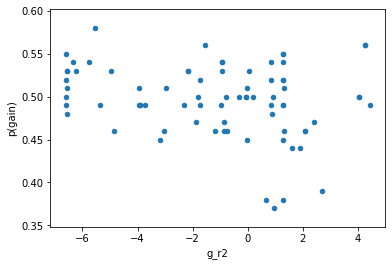

In [17]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

### Regression

In [55]:
taxi_vehicle_collision_predictions, taxi_vehicle_collision_regr_explanations = predict_value_for_features(
    rf_regressor,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR
)

Mean Absolute Error: 9.3876
Mean Squared Error: 1779.6816
Median Absolute Error: 2.2070
R2 Score: -181.6842


In [56]:
print_df(taxi_vehicle_collision_predictions)

                                                                        candidate_name      cf     real  predicted
0                                                                     DHS Daily Report 0.97238  4.43722    0.00758
1                         Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    1.60109
2                         Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    1.60109
3           Performance Metrics - Buildings - Time to Issue Developer Services Permits 0.14365  4.02944    0.04510
4           Performance Metrics - Buildings - Time to Issue Developer Services Permits 0.14365  4.02944    0.04510
5                                                            Daily Weather Data for NY 1.00000  2.69791    0.01579
6                                              CTA - Ridership - Daily Boarding Totals 1.00000  2.42632    0.04974
7                        Performance Metrics - Buildings - Time To Issue Green P

In [57]:
taxi_vehicle_collision_regr_explanations[5]

,target,feature,weight,value
0,y,candidate_target_max_covariance,286.10360,9551887.31111
1,y,<BIAS>,1.98085,1.00000
2,y,query_max_skewness,0.09887,1.40835
3,y,query_num_of_columns,0.08742,2.00000
4,y,query_target_max_covariance,0.06946,176158.30261
5,y,candidate_target_max_pearson,0.05479,0.04764
6,y,query_num_of_rows,0.02633,181.00000
7,y,containment_fraction,-0.00469,0.03315
8,y,candidate_max_kurtosis,-0.00545,0.35314
9,y,candidate_max_skewness,-0.00678,0.64483


## College Debt

### Classification

In [18]:
college_debt_classes, college_debt_explanations = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR
)

In [19]:
compute_precision_recall(college_debt_classes)

-- TP: 2
                                         name    g_r2  p(gain)      cf
0  Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.66000 1.00000
1        College Scorecard Data - Most Recent 0.72774  0.67000 1.00000

-- TN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FP: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

Precision: 1.0000
Recall: 1.0000


In [20]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan

In [21]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

nan

In [22]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

-1.0

### Regression

In [58]:
college_debt_predictions, college_debt_regr_explanations = predict_value_for_features(
    rf_regressor,
    'college-debt-records-features',
    FEATURE_VECTOR
)

Mean Absolute Error: 0.7780
Mean Squared Error: 0.6068
Median Absolute Error: 0.7780
R2 Score: -374.6633


In [59]:
print_df(college_debt_predictions)

                               candidate_name      cf    real  predicted
0  Most- Recent- Cohorts- Scorecard- Elements 1.00000 0.80812   -0.00855
1        College Scorecard Data - Most Recent 1.00000 0.72774   -0.01164


## Poverty Estimation

### Classification

In [23]:
poverty_estimation_classes, poverty_estimation_explanations = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR
)

In [24]:
compute_precision_recall(poverty_estimation_classes)

-- TP: 1
                     name    g_r2  p(gain)      cf
0  Unemployment in the US 0.02825  0.60000 1.00000

-- TN: 2
                              name     g_r2  p(gain)      cf
7  SF Development Pipeline 2016 Q3 -0.31018  0.49000 0.00128
8  SF Development Pipeline 2019 Q2 -0.31780  0.49000 0.00128

-- FP: 6
                              name     g_r2  p(gain)      cf
1  SF Development Pipeline 2017 Q2 -0.29071  0.51000 0.00128
2  SF Development Pipeline 2016 Q4 -0.29903  0.51000 0.00159
3  SF Development Pipeline 2017 Q3 -0.29914  0.50000 0.00128
4  SF Development Pipeline 2014 Q4 -0.29982  0.54000 0.00032
5  SF Development Pipeline 2017 Q1 -0.30170  0.51000 0.00128
6  SF Development Pipeline 2016 Q2 -0.30469  0.53000 0.00064

-- FN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

Precision: 0.1429
Recall: 1.0000


In [25]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.9976101832348241

In [26]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

0.8747353381107459

In [27]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.8883507458393166

In [63]:
poverty_estimation_explanations[0]

,target,feature,weight,value
0,loss,<BIAS>,0.43948,1.00000
1,loss,query_num_of_columns,0.08154,43.00000
2,loss,candidate_target_max_pearson,0.04695,0.02414
3,loss,query_target_max_spearman,0.03439,0.69943
4,loss,query_row_column_ratio,0.03024,72.93023
5,loss,query_target_max_pearson,0.01840,0.29724
6,loss,query_max_kurtosis,0.01599,401.98953
7,loss,candidate_num_rows,0.01589,1585.00000
8,loss,candidate_row_column_ratio,0.01423,54.65517
9,loss,query_target_max_mutual_info,0.01077,0.84828


### Regression

In [61]:
poverty_estimation_predictions, poverty_estimation_regr_explanations = predict_value_for_features(
    rf_regressor,
    'poverty-estimation-records-features',
    FEATURE_VECTOR
)

Mean Absolute Error: 0.4188
Mean Squared Error: 0.4378
Median Absolute Error: 0.1825
R2 Score: -39.2300


In [62]:
print_df(poverty_estimation_predictions)

                    candidate_name      cf     real  predicted
0           Unemployment in the US 1.00000  0.02825    0.17675
1  SF Development Pipeline 2017 Q2 0.00128 -0.29071   -0.47321
2  SF Development Pipeline 2016 Q4 0.00159 -0.29903   -0.71281
3  SF Development Pipeline 2017 Q3 0.00128 -0.29914   -0.46785
4  SF Development Pipeline 2014 Q4 0.00032 -0.29982    1.52253
5  SF Development Pipeline 2017 Q1 0.00128 -0.30170   -0.71675
6  SF Development Pipeline 2016 Q2 0.00064 -0.30469   -0.35561
7  SF Development Pipeline 2016 Q3 0.00128 -0.31018   -0.71228
8  SF Development Pipeline 2019 Q2 0.00128 -0.31780   -0.48299
